In [1]:
!pip install -qU transformers

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader

In [3]:
with open('/kaggle/input/ferdowsi-poems/ferdousi.txt', 'r') as f:
    verses = f.readlines()
verses.pop(-1)
for i in range(len(verses)):
    verses[i] = verses[i].removesuffix("\n")

In [4]:
print(verses[0])
print(verses[1])
print(verses[2])
print(verses[3])

print(verses[-4])
print(verses[-3])
print(verses[-2])
print(verses[-1])

به نام خداوند جان و خرد
کزین برتر اندیشه برنگذرد
خداوند نام و خداوند جای
خداوند روزی ده رهنمای
چواین نامور نامه آمد ببن
ز من روی کشور شود پرسخن
از آن پس نمیرم که من زنده ام
که تخم سخن من پراگنده ام


In [5]:
verses_ = []
for i in range(len(verses)//2):
    verses_.append(verses[2*i] +"\n"+ verses[2*i+1])

In [6]:
def create_train_test(v, test_ratio):
    test_size = int(test_ratio*len(v))
    train_size = len(v) - test_size
    train_dataset, test_dataset = random_split(v, [train_size, test_size])

    return train_dataset, test_dataset

In [7]:
import pandas as pd
import numpy as np

from pathlib import Path

import torch
from transformers import AutoTokenizer, AutoConfig, AutoModelWithLMHead

from IPython import display

In [8]:
import random
import numpy as np

model_name_or_path = "HooshvareLab/gpt2-fa"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelWithLMHead.from_pretrained(model_name_or_path)
model.config.pad_token_id = model.config.eos_token_id

device = torch.device("cuda")

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

tokenizer_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/875k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/14.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/auto/modeling_auto.py:1564: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/485M [00:00<?, ?B/s]

In [9]:
from torch.nn.utils.rnn import pad_sequence

torch.manual_seed(42)

class FerdowsiDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.tokenizer = tokenizer
        self.ids = []
        self.attn = []
        for v in data:
            encodings_dict = tokenizer(v,
                                       truncation=True,
                                       padding=True)

            self.ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn.append(torch.tensor(encodings_dict['attention_mask']))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.attn[idx]

In [10]:
train_, test_ = create_train_test(verses_, 0.02)
train_dataloader = DataLoader(FerdowsiDataset(train_, tokenizer), batch_size=4, shuffle=True,
                             collate_fn=lambda x: (pad_sequence([item[0] for item in x], batch_first=True),
                                                   pad_sequence([item[1] for item in x], batch_first=True)))
test_dataloader = DataLoader(FerdowsiDataset(test_, tokenizer), batch_size=4, shuffle=False,
                             collate_fn=lambda x: (pad_sequence([item[0] for item in x], batch_first=True),
                                                   pad_sequence([item[1] for item in x], batch_first=True)))

In [11]:
epochs = 6
warmup_steps = 1e2
sample_every = 300

In [12]:
from transformers import AdamW

# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters.
optimizer = AdamW(
    model.parameters(),
    lr=5e-4,
    eps=1e-8
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps)


In [14]:
import random
import time
import datetime
from tqdm import tqdm


def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))


total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in tqdm(range(0, epochs), position=0):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0):

        b_input_ids = batch[0].to(device)
        b_att = batch[1].to(device)
        b_labels = b_input_ids
        
        model.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_att, labels=b_labels)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print()
    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    print()

    t0 = time.time()

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

  0%|          | 0/6 [00:00<?, ?it/s]

Beginning epoch 1 of 6


 17%|█▋        | 1/6 [09:12<46:03, 552.77s/it]


Average Training Loss: 3.9525946207652267. Epoch time: 0:09:13

Beginning epoch 2 of 6


 33%|███▎      | 2/6 [18:24<36:48, 552.22s/it]


Average Training Loss: 3.1682423246873923. Epoch time: 0:09:12

Beginning epoch 3 of 6


 50%|█████     | 3/6 [27:33<27:31, 550.50s/it]


Average Training Loss: 2.7580063121480065. Epoch time: 0:09:08

Beginning epoch 4 of 6


 67%|██████▋   | 4/6 [36:42<18:20, 550.14s/it]


Average Training Loss: 2.3475036331946977. Epoch time: 0:09:10

Beginning epoch 5 of 6


 83%|████████▎ | 5/6 [45:52<09:09, 549.99s/it]


Average Training Loss: 1.8863942261901128. Epoch time: 0:09:10

Beginning epoch 6 of 6


100%|██████████| 6/6 [54:58<00:00, 549.70s/it]


Average Training Loss: 1.4425422736781197. Epoch time: 0:09:06

Total training took 0:54:58


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


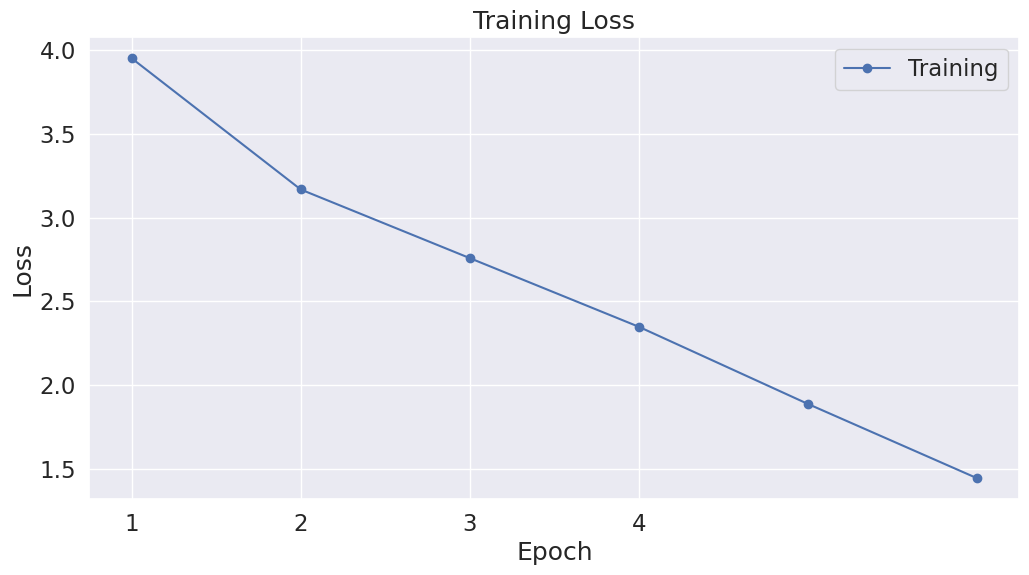

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")

# Label the plot.
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [16]:

total_loss = 0.0
total_tokens = 0

model.eval()

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        b_input_ids = batch[0].to(device)
        b_att = batch[1].to(device)
        b_labels = b_input_ids

        outputs = model(b_input_ids, attention_mask=b_att, labels=b_labels)

        loss = outputs.loss
        total_loss += loss.item()
        total_tokens += b_labels.numel()

perplexity = torch.exp(torch.tensor(total_loss) / total_tokens)
print(f"Perplexity: {perplexity}")


100%|██████████| 248/248 [00:03<00:00, 81.21it/s]


Perplexity: 1.0566248893737793


In [21]:
def gen_test(prompt):
    sample_input = prompt
    sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
    sample_input_ids = sample_input_ids.to(device)

    sample_outputs = model.generate(
         input_ids=sample_input_ids,
         do_sample=True,
         top_k=50,
         max_length=20,
         top_p=0.95,
         num_return_sequences=1
    )
    for i, sample_output in enumerate(sample_outputs):
        gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=True)
        gen_sample_output = gen_sample_output.replace("<s>", "")
        gen_sample_output = gen_sample_output.replace("</s>", "")
        print(f'{gen_sample_output}')
        print()
        print()

In [22]:
gen_test("اگر آن ترک")
gen_test("مرا ای دوست")
gen_test("آب زنید راه را")

اگر آن ترک آید به چنگ اندرون
گر آهنگ این اژدها بسپرد خون


مرا ای دوست آمد که او هست سام
بپوشد ز من نام تا من به نام


آب زنید راه را جایگاه
بدو اندرون کرم بد بی سپاه


